In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from scipy.sparse import coo_matrix
import xgboost as xgb

In [2]:
df = pd.read_json('./reviews_Musical_Instruments_5.json', lines=True)

In [3]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,1384719342,"[0, 0]",5,"Not much to write about here, but it does exac...","02 28, 2014",A2IBPI20UZIR0U,"cassandra tu ""Yeah, well, that's just like, u...",good,1393545600
1,1384719342,"[13, 14]",5,The product does exactly as it should and is q...,"03 16, 2013",A14VAT5EAX3D9S,Jake,Jake,1363392000
2,1384719342,"[1, 1]",5,The primary job of this device is to block the...,"08 28, 2013",A195EZSQDW3E21,"Rick Bennette ""Rick Bennette""",It Does The Job Well,1377648000
3,1384719342,"[0, 0]",5,Nice windscreen protects my MXL mic and preven...,"02 14, 2014",A2C00NNG1ZQQG2,"RustyBill ""Sunday Rocker""",GOOD WINDSCREEN FOR THE MONEY,1392336000
4,1384719342,"[0, 0]",5,This pop filter is great. It looks and perform...,"02 21, 2014",A94QU4C90B1AX,SEAN MASLANKA,No more pops when I record my vocals.,1392940800


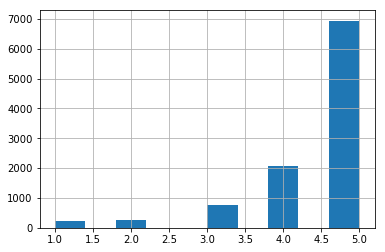

In [4]:
df.overall.hist();
plt.show();

In [5]:
df[df.overall==4].iloc[7].reviewText

'This cable seems like it will last me for a while. As it is only being used to connect a DI box it will not get abused as much as the vocal mics always do.'

In [6]:
df['pos'] = np.where(df.overall > 3, 1, 0)
class_imb = 1-(df.pos.sum()/len(df))
print(class_imb)

0.120748465062


In [7]:
df['reviewText'] = df.reviewText.str.lower()

In [22]:
sw = [
    'a',
    'an',
    'as',
    'are',
    'at',
    'be',
    'by',
    'for',
    'from',
    'has',
    'he',
    'in',
    'is',
    'its',
    'it',
    'of',
    'on',
    'the',
    'and',
    'to',
    'at',
    'for',
    'was',
    'were',
    'will',
    'with'
]

tv = TfidfVectorizer(max_features=5000, ngram_range=(1, 5), stop_words=sw, min_df=.2, max_df=.8)
tv.fit(df.reviewText)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=5000, min_df=0.2,
        ngram_range=(1, 5), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['a', 'an', 'as', 'are', 'at', 'be', 'by', 'for', 'from', 'has', 'he', 'in', 'is', 'its', 'it', 'of', 'on', 'the', 'and', 'to', 'at', 'for', 'was', 'were', 'will', 'with'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

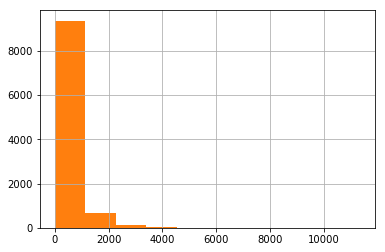

In [28]:
df['review_length'] = df.reviewText.apply(len)
df = df[df.review_length > 0] 

df.review_length.hist()
plt.show();

In [23]:
features = tv.transform(df.reviewText)

In [37]:
m = coo_matrix(np.array([[0,0,1],[1,0,0],[1,0,0]]))
a = np.ones(m.shape)

scipy.sparse.vstack((a, m))

<6x3 sparse matrix of type '<class 'numpy.float64'>'
	with 12 stored elements in COOrdinate format>

In [46]:
cutoff = int(.5 * len(df))

train = df[:cutoff]
ft_train = scipy.sparse.hstack((features[:cutoff], np.array(df.review_length[:cutoff]).reshape(-1, 1)))

test = df[cutoff:]
ft_test = scipy.sparse.hstack((features[cutoff:], np.array(df.review_length[cutoff:]).reshape(-1, 1)))


Y_train = train.pos
Y_test = test.pos

In [45]:
ft_test

<5127x26 sparse matrix of type '<class 'numpy.float64'>'
	with 43574 stored elements in Compressed Sparse Row format>

In [12]:
dtrain = xgb.DMatrix(ft_train, label=Y_train)
dtest = xgb.DMatrix(ft_test, label=Y_test)
param = {
    'max_depth': 3, 
    'eta': .1, 
    'silent': 0, 
    'objective': 
    'binary:logistic', 
    'scale_pos_weight': (class_imb),
    'nthread':4,
    'eval_metric':'auc'
}

plst = param.items()
num_round = 500
bst = xgb.train(plst, dtrain, num_round)

In [13]:
Y_ = np.where(bst.predict(dtrain)>.5, 1, 0)
tb = pd.crosstab(Y_, Y_train)
print(tb)
print((tb.iloc[0, 0]+tb.iloc[1, 1])/tb.sum().sum())

pos      0     1
row_0           
0      521   645
1       40  3921
0.866393602497


In [14]:
Y_ = np.where(bst.predict(dtest)>.5, 1, 0)
tb = pd.crosstab(Y_, Y_test)
print(tb)
print((tb.iloc[0, 0]+tb.iloc[1, 1])/tb.sum().sum())

pos      0     1
row_0           
0      265   873
1      413  3576
0.749171055198


In [50]:
def print_model_results(dpth=3, eta=.1, n_estimators=100, cst=1):
    dtrain = xgb.DMatrix(ft_train, label=Y_train)
    dtest = xgb.DMatrix(ft_test, label=Y_test)
    param = {
        'max_depth': dpth, 
        'eta': eta, 
        'silent': 0,
        'objective' : 'binary:logistic', 
        'scale_pos_weight': (class_imb),
        'nthread':4,
        'eval_metric':'auc',
        'colsample_bytree': cst
    }

    plst = param.items()
    num_round = n_estimators
    bst = xgb.train(plst, dtrain, num_round)

    Y_ = np.where(bst.predict(dtrain)>.5, 1, 0)
    tb = pd.crosstab(Y_, Y_train)
    print(tb)
    print((tb.iloc[0, 0]+tb.iloc[1, 1])/tb.sum().sum())

    Y_ = np.where(bst.predict(dtest)>.5, 1, 0)
    tb = pd.crosstab(Y_, Y_test)
    print(tb)
    print((tb.iloc[0, 0]+tb.iloc[1, 1])/tb.sum().sum())
    
print_model_results(n_estimators=1000, eta=.2, dpth=6, cst=1)

pos      0     1
row_0           
0      561    14
1        0  4552
0.997269358299
pos      0     1
row_0           
0      100   283
1      578  4166
0.832065535401


In [42]:
def record_model_results(results, dpth=3, eta=.1, n_estimators=100, cst=1):
    dtrain = xgb.DMatrix(ft_train, label=Y_train)
    dtest = xgb.DMatrix(ft_test, label=Y_test)
    param = {
        'max_depth': dpth, 
        'eta': eta, 
        'silent': 0,
        'objective' : 'binary:logistic', 
        'scale_pos_weight': (class_imb),
        'nthread':4,
        'eval_metric':'auc',
        'colsample_bytree': cst
    }

    plst = param.items()
    num_round = n_estimators
    bst = xgb.train(plst, dtrain, num_round)

    Y_tr = np.where(bst.predict(dtrain)>.5, 1, 0)
    tb_train = pd.crosstab(Y_tr, Y_train)

    Y_te = np.where(bst.predict(dtest)>.5, 1, 0)
    tb_test = pd.crosstab(Y_te, Y_test)
    next_row = pd.DataFrame(columns=results.columns, index=[len(results)])
    next_row['n_estimators'] = num_round
    next_row['params'] = [param]
    next_row['train_tab'] = [tb_train]
    next_row['train_acc'] = (tb_train.iloc[0, 0]+tb_train.iloc[1, 1])/tb_train.sum().sum()
    next_row['test_tab'] = [tb_test]
    next_row['test_acc'] = (tb_test.iloc[0, 0]+tb_test.iloc[1, 1])/tb_test.sum().sum()
    results = pd.concat([results, next_row], axis=0)
    return results

In [41]:
cols = [
    'params',
    'n_estimators',
    'train_tab',
    'train_acc',
    'test_tab',
    'test_acc'
]

results = pd.DataFrame(columns=cols)

In [64]:
itt = 0
for n in range(1000, 3000, 100):
    for eta in range(8, 30, 3):
        eta = eta/100
        for dp in range(2, 8):
            for cst in range(3, 6):
                print('round number: ', itt)
                itt += 1
                cst = cst/10
                results = record_model_results(results, dpth=dp, eta=eta, n_estimators=n, cst=cst)

round number:  0


KeyboardInterrupt: 

In [69]:
results.loc[results.test_acc.idxmax()].test_acc

0.86580846498927244

In [60]:
len(results)

531

In [70]:
tv?